<a href="https://colab.research.google.com/github/bongkyunSON/Deep_Leaning/blob/main/LDA_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 토픽모델링을 통한 키워드 분석

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. 사용할 라이브러리/데이터 불러오기 

In [ ]:
!pip install konlpy pecab gensim
!curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
+ mecab_dicdir=/usr/local/lib/mecab/dic/mecab-ko-dic
+ set -e
++ uname
+ os=Linux
+ [[ ! Linux == \L\i\n\u\x ]]
+ hash sudo
+ sudo=sudo
+ python=python3
+ hash pyenv
+ at_user_site=
++ check_python_site_location_is_writable
++ python3 -
+ [[ 1 == \0 ]]
+ hash automake
+ hash mecab
+ echo 'mecab-ko is already installed'
mecab-ko is already installed
+ [[ -d /usr/local/lib/mecab/dic/mecab-ko-dic ]]
+ echo 'mecab-ko-dic is already installed'
mecab-ko-dic is already installed
++ python3 -c 'import pkgutil; print(1 if pkgutil.find_loader("MeCab") else 0)'
+ [[ 1 == \1 ]]
+ echo 'mecab-python is already installed'
mecab-python is already installed
+ echo Done.
Done.


In [ ]:
import sys
from sklearn.feature_extraction.text import CountVectorizer
from tqdm.notebook import tqdm  # progress bar
from konlpy.tag import Mecab; mecab = Mecab()
from konlpy.tag import Komoran; komoran = Komoran()

import numpy as np
import pandas as pd
import string
import re
import warnings
from gensim import corpora
from gensim import models
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
%matplotlib inline

## 운영체제별 글꼴 세팅

# 그래프를 이쁘게 그리기 위한 코드입니다. 한글 글꼴을 추가합니다.

%matplotlib inline  

import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도
import seaborn as sns
mpl.rcParams['axes.unicode_minus'] = False

sys_font=fm.findSystemFonts()
print(f"sys_font number: {len(sys_font)}")
print(sys_font)

nanum_font = [f for f in sys_font if 'Nanum' in f]
print(f"nanum_font number: {len(nanum_font)}")

!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져옵니다.
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()

sys_font number: 48
['/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Regular.ttf', '/usr/share/fonts/truetype/nanum/NanumGothic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf', '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf', '/usr/share/fonts/truetype/humor-sans/Humor-Sans.ttf', '/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf', '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-BoldItalic.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareL.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareB.ttf', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf', '/usr/share/fonts/truetype/nanum/NanumGothicEcoBold.ttf', '/usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareR.ttf', '/usr/share/fonts/truetype/n

In [ ]:
# Colab Notebooks

## 크롤링한 파일이 바뀌면, 경로도 수정되어야 합니다.
data_path = '/content/drive/MyDrive/Colab Notebooks/DeepLearning/data/애플_(2022.01.01_2022.12.06).xlsx'

In [ ]:
import pandas as pd

documents = pd.read_excel(data_path)['contents'].dropna() # 빈 문서 제거.
documents

0       애플페이 도입에 ‘확인 불가’…소비자 ‘답답’MST 단말기 대부분인데…애플 NFC ...
1       기사내용 요약NFC 단말기 보조금 지급, 정보 유출 방지 대책 등 검토 필요    ...
2       [파이낸셜뉴스]       애플이 중국 이외 지역 생산 확대를 시도하는 가운데 지난...
3       위니아·위니아에이드 등 급등금감원 애플페이 약관심사 완료이르면 올해 안에 공식 출시...
4       애플페이, 비자에 이어 '세계 결제 규모 2위'    금융위, 애플페이 카드·전자금...
                              ...                        
4669    [편집자주] '오미주'는 '오늘 주목되는 미국 주식'의 줄인 말입니다. 주가에 영향...
4670    애플, "9월 8일 아이폰14 공개" 발표크기 작은 '미니' 대신 화면 키운 '맥스...
4671    ■ 경제와이드 모닝벨 '글로벌 비즈' - 고유미 외신캐스터글로벌 비즈입니다.◇ 애플...
4672    올해 한국문학번역상 번역대상 수상자로 고은지와 마시 카라브레타 칸시오 벨로, 유신신...
4673    [편집자주] '오미주'는 '오늘 주목되는 미국 주식'의 줄인 말입니다. 주가에 영향...
Name: contents, Length: 4662, dtype: object

## 2. 전처리 함수 정의하기 

In [ ]:
def text_cleaning(doc):
    # 한국어를 제외한 글자를 제거하는 패턴.
    #doc = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", doc)
    
    # 특수문자를 제거하는 패턴.
    doc = re.sub("[\{\}\[\]\/?.,;:|\)*~`!^\-_+<>@\#$%&\\\=\(\'\"]", " ", doc)
    
    # 영문 빼고 모두 제거하는 패턴.
    #doc = doc.replace("\n", " ")
    #doc = re.sub("[^A-Za-z ]", "", doc)
    
    return doc

def define_stopwords(path):
    
    SW = set()
    # 불용어를 추가하는 방법 1.
    # SW.add("있다")
    SW.add("있어요")
    
    # 불용어를 추가하는 방법 2.
    # stopwords-ko.txt에 직접 추가
    
    with open(path, encoding="utf-8") as f:
        for word in f:
            SW.add(word.strip())
            
    return SW

def text_tokenizing(doc, tokenizer):
    """
    Input Parameter :
    
    doc - tokenizing 하는 실제 데이터.
    tokenizer - token의 단위.
    """
    # 불용어(SW)에 포함되어 있지 않고, 두 글자 이상인 token(형태소)만 사용하겠다.
    
    if tokenizer == "words":
        return [token for token in doc.split() if (token not in SW) and (len(token) >= 2)]
    
    elif tokenizer == "nouns":
        return [token for token in mecab.nouns(doc) if (token not in SW) and (len(token) >= 2)] # 주어진 텍스트에서 명사만 뽑아서 리스트로 반환.
        
    elif tokenizer == "morphs":
        return [token for token in mecab.morphs(doc) if (token not in SW) and (len(token) >= 2)] # 주어진 텍스트에서 형태소 단위로 잘라서 리스트로 반환.

In [ ]:
tokenizer = 'nouns'
SW = define_stopwords('/content/drive/MyDrive/Colab Notebooks/DeepLearning/data/stopwords-ko.txt')
tokenized_documents = [text_tokenizing(text_cleaning(doc), tokenizer=tokenizer) for doc in documents]

In [ ]:
print(len(tokenized_documents))
print(tokenized_documents[0])

4662
['애플', '페이', '도입', '확인', '불가', '소비자', '단말기', '대부분', '애플', '단말기', '도입', '고수', '부실', '결제', '시장', '논란', '애플', '페이', '이미지', '사진', '애플', '애플', '페이', '감자', '애플', '현대', '카드', '해당', '서비스', '도입', '추진', '소식', '소비자', '관심', '집중', '애플', '묵묵부답', '공식', '입장', '그간', '한국', '시장', '찬밥', '취급', '비판', '애플', '구설수', '이유', '애플', '애플', '페이', '한국', '시장', '도입', '확인', '불가', '입장', '고수', '도입', '시기', '예정', '소식', '서비스', '애플', '관련', '공식', '입장', '답변', '아이폰', '국내', '시장', '점유', '기준', '데이터', '아이폰', '이용', '아이폰', '유저', '입장', '애플', '페이', '도입', '단비', '소식', '애플', '페이', '해외', '대중', '한국', '이용', '대표', '서비스', '단말기', '비용', '애플', '현대', '카드', '가맹점', '줄다리기', '애플', '페이', '침묵', '애플', '고압', '태도', '근본', '문제', '지배', '모바일', '결제', '시스템', '근거리', '무선', '통신', '마그네', '보안', '전송', '국내', '시장', '마그네', '저장', '정보', '무선', '자리', '국내', '대부분', '신용', '카드', '가맹점', '해당', '방식', '사용', '삼성전자', '삼성', '페이', '시장', '상황', '반영', '개발', '반면', '애플', '방식', '고수', '단말기', '보급', '문제', '유다', '애플', '페이', '국내', '시장', '안착', '업계', '추산', '단말기', '보급', '투입', '애플', '방식', '도입', '입장

### gensim LDA model을 사용하기 위한 자료구조 생성. 

In [ ]:
# 문서-단어 행렬 만들기
# 어휘(vocabulary) 학습
dictionary = corpora.Dictionary(tokenized_documents)
# 문서-단어 행렬 생성
corpus = [dictionary.doc2bow(document) for document in tokenized_documents]

In [ ]:
NUM_TOTAL_WORDS = len(dictionary)
print(dictionary)
print(NUM_TOTAL_WORDS)

Dictionary(11867 unique tokens: ['가게', '가맹점', '감당', '감자', '개발']...)
11867


## 3. 토픽 모델링(LDA Model)


- LDA(Latent Dirichlet Allocation) : 단어들의 조합(토픽)이 하나의 토픽을 구성하고, 각 단어가 그 토픽에 할당될 확률을 계산합니다.

- LDA는 사람이 글을 쓰는 과정을 다음과 같이 가정합니다.

1) 여러 개의 토픽을 정한다.

2) 토픽 하나를 고릅니다.

3) 토픽 내에 속하는 단어 하나를 고릅니다.

4) 해당 단어를 글에 적습니다.

5) 2번 과정부터 반복하면서 글을 적습니다.


-> LDA는 사람이 글을 쓰는 과정을 따라하면서 글을 생성하는 과정을 학습합니다. (Generative Model)

-> LDA는 생성을 통해서, 저자가 생각한 토픽의 분포(단어들의 확률 분포)를 찾습니다.

In [ ]:
# ldamodel 선언
from gensim.models.ldamodel import LdaModel

# Coherence model 선언 (LDA의 정량 평가 지표.)
from gensim.models.coherencemodel import CoherenceModel

In [ ]:
# 토픽 개수와 토픽 별 상위 추출 단어 개수 지정.

def build_doc_term_mat(documents):
    """주어진 문서 집합으로 문서-어휘 행렬을 만들어 돌려준다."""
    
    print_log_msg("Building document-term matrix.")
    dictionary = corpora.Dictionary(documents)
    corpus = [dictionary.doc2bow(document) for document in documents]

    return corpus, dictionary


def print_topic_words(model):
    """토픽별 토픽 단어들을 화면에 인쇄한다."""
    
    print_log_msg("Printing topic words.")
    
    for topic_id in range(model.num_topics):
        topic_word_probs = model.show_topic(topic_id, 30)
        print("Topic ID: {}".format(topic_id))

        for topic_word, prob in topic_word_probs:
            print("\t{}\t{}".format(topic_word, prob))

        print("\n")


def print_log_msg(msg):
    """로그 메시지를 출력한다."""
    
    print(msg, flush=True)

In [ ]:
def compute_coherence(dictionary, corpus, texts, start, end, step):
    '''
    start, end+1, step에 해당하는 토픽 개수를 입력받아서 LdaModel을 수행하고, 그 때의 Coherence Score를 함께 돌려주는 함수.
    '''
    coherence_score_list = []
    model_list = []
    for num_topics in tqdm(range(start, end+1, step)):
        model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,  # 몇 개의 토픽을 찾을건지!
                         passes=10,        #학습 반복 횟수
                         random_state=42)
        
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=tokenized_documents, dictionary=dictionary, coherence='c_v')
        coherence_score_list.append(coherence_model.get_coherence())
        
    return model_list, coherence_score_list

In [ ]:
# LDA에서 가장 중요한 파라미터 = K(토픽 개수)
start, end, step = [int(x) for x in input("원하는 토픽 갯수들을 입력하세요(e.g. 2,5,1)").split(",")]
start, end, step

원하는 토픽 갯수들을 입력하세요(e.g. 2,5,1)2,6,1


(2, 6, 1)

In [ ]:
corpus, dictionary = build_doc_term_mat(tokenized_documents)
print(len(corpus), len(dictionary))


model_list, coherence_scores = compute_coherence(dictionary=dictionary, corpus=corpus, 
                                                texts=tokenized_documents, start=start, end=end, step=step)

Building document-term matrix.
4662 11867


  0%|          | 0/5 [00:00<?, ?it/s]

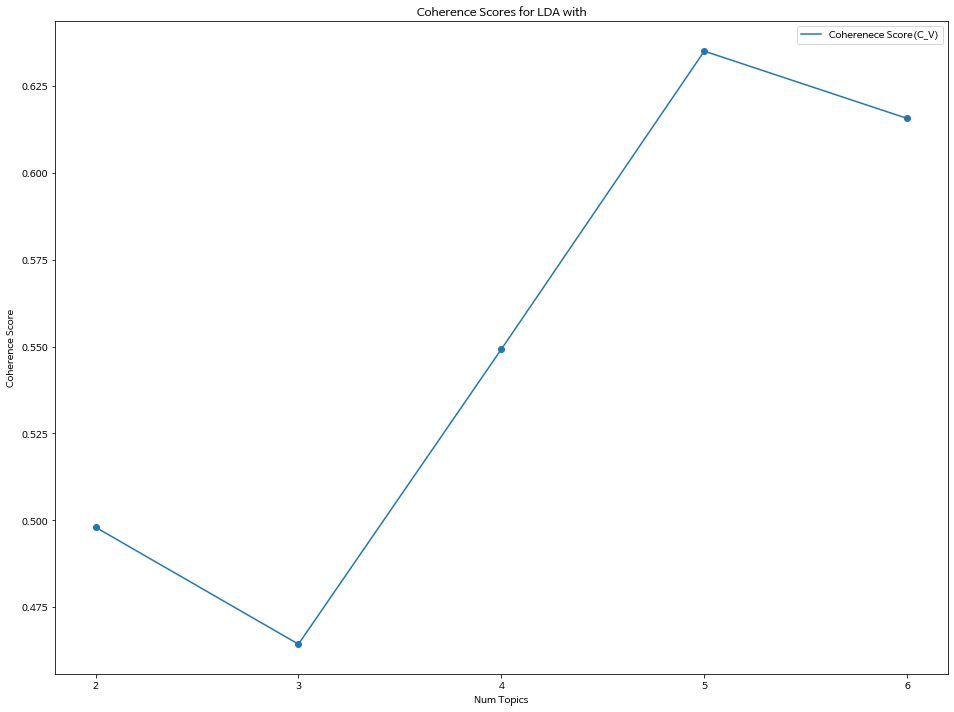

In [ ]:
coherence_list = coherence_scores
label = "Coherenece Score(C_V)"

x = range(start, end+1, step)
plt.figure(figsize=(16, 12))
plt.xticks(x)
plt.plot(x, coherence_list, label=label)
plt.scatter(x, coherence_list)
plt.title(f"Coherence Scores for LDA with")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Score")
plt.legend(loc='best')
plt.show()

In [ ]:
selected_model = model_list[np.argmax(coherence_list)] # coherence score가 가장 높은 LDA model을 selected_model로 할당.
selected_model.num_topics

5

### 4. pyLDAvis를 이용한 시각화 

In [ ]:
!pip install pyldavis==3.2.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.1 MB/s 
  Created wheel for pyldavis: filename=pyLDAvis-3.2.1-py2.py3-none-any.whl size=136188 sha256=a610519e12be2091d26fcc3ffdcd9bfd4b19f49c4957065b7d9c20538e4bd745
  Stored in directory: /root/.cache/pip/wheels/ae/5f/79/278ffb79ffde795f9686b558a8e313971ee0d3a914105d57dd
Successfully built pyldavis


In [ ]:
# pyLDAvis 불러오기
import pyLDAvis
import pyLDAvis.gensim

# pyLDAvis를 jupyter notebook에서 실행할 수 있게 활성화.
pyLDAvis.enable_notebook()

# pyLDAvis 실행.
data = pyLDAvis.gensim.prepare(selected_model, corpus, dictionary)
data

/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable
/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.098420  0.026917       1        1  34.604416
0      0.116055 -0.059694       2        1  22.217602
1      0.142082  0.289006       3        1  20.082728
3      0.098571 -0.277048       4        1  11.802542
4     -0.455127  0.020818       5        1  11.292712, topic_info=     Term          Freq         Total Category  logprob  loglift
757    번역   9636.000000   9636.000000  Default  30.0000  30.0000
8701   문학   7823.000000   7823.000000  Default  29.0000  29.0000
102    애플  71440.000000  71440.000000  Default  28.0000  28.0000
176    한국  11651.000000  11651.000000  Default  27.0000  27.0000
429    주가   8784.000000   8784.000000  Default  26.0000  26.0000
...   ...           ...           ...      ...      ...      ...
712    대상   2413.250339   3361.595773   Topic5  -4.0580   1.8496
1553   인상   2413.960348   5035.124380   Topic5  -4.0577   1.4458
248    올해   1806.191544   5465.388367   Topic5  -4.3478   1.0738
41     대표   1206.200204   2350.147598   Topic5  -4.7515   1.5140
1242   일본   1205.834406   1561.044209   Topic5  -4.7518   1.9228

[325 rows x 6 columns], token_table=       Topic      Freq Term
term                       
730        1  0.376791   가격
730        2  0.623074   가격
182        1  0.999245   가능
1202       1  0.077058   가량
1202       2  0.461620   가량
...      ...       ...  ...
1475       1  0.001822   화면
1475       2  0.998049   화면
2767       1  0.020269   확정
2767       2  0.979680   확정
11070      3  0.998308   흥분

[434 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 4, 5])